<a href="https://colab.research.google.com/github/statistics-jun/2022-1-ESAA/blob/main/ESAA_Week1_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2022-1 ESAA 5기 김혜준 개념 필사 - 0311(금) 1주차 과제
 
## <핸즈온 머신러닝>
## Chapter 3 분류

### 3.1 MNIST
* MNIST : 손으로 쓴 70,000개의 작은 숫자 이미지를 모은 데이터셋
 - 각 이미지는 어떤 숫자를 나타내는지 레이블 되어 있음



In [ ]:
# MNIST 데이터셋을 내려받는 코드
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False) # 아래 과정에서 일어나는 오류 해결 위해 as_frame=False를 이용하여 MNIST 데이터셋을 numpy.ndarray 형태로 불러옴
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

* 사이킷런 데이터셋의 일반적인 딕셔너리 구조
 
 - 데이터 셋을 설명하는 DESCR 키
 - 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
 - 레이블 배열을 담은 target 키



In [ ]:
X, y = mnist["data"], mnist["target"]

In [ ]:
X.shape

(70000, 784)

In [ ]:
y.shape

(70000,)

* 70000개의 이미지, 각 이미지에는 784개의 특성
  - 이미지가 28 * 28 픽셀이기 때문
  - 각 특성은 0(흰색)부터 255(검은색)까지의 픽셀 강도



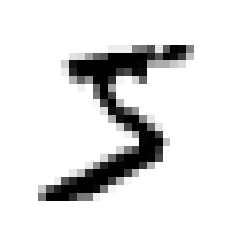

In [ ]:
# 데이터셋에서 이미지 확인
import matplotlib as mpl
import matplotlib.pyplot as plt

# some_digit = X[0]
# 오류 발생 (KeyError)
# 원인 : fetch_openml 0.24.0 버전부터 as_frame argument의 default 옵션이 False(numpy.ndarray를 반환)에서 auto(pandas.DataFrame을 반환)로 변경되었기 때문
# 해결 방법 #1 : to_numpy()를 사용해 pandas.DataFrame인 X를 numpy.ndarray로 바꾸기
# 해결 방법 #2 : fetch_openml의 as_frame argument를 False로 설정히여 mnist 데이터셋 불러오기
# 출처 : https://stackoverflow.com/questions/65506131/why-does-using-x0-in-mnist-classifier-code-give-me-an-error 
some_digit = X[0] # 샘플의 특성 벡터 추출
some_digit_image = some_digit.reshape(28, 28) # 28 * 28 배열로 크기 변환

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [ ]:
# 실제 레이블 확인
y[0]

'5'

In [ ]:
# 문자열 레이블 y를 정수로 변환
import numpy as np # 넘파이 호출
y = y.astype(np.uint8)

In [ ]:
# 훈련(앞쪽 60,000개 이미지) / 테스트(뒤쪽 10,000개 이미지) 세트 분리
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 3.2 이진 분류기 훈련
* 이진 분류기 예시 : 숫자 5만 식별하는 '5-감지기'
  - '5'와 '5 아님' 두 개의 클래스를 구분

In [ ]:
# 분류 작업을 위한 타깃 벡터 생성
y_train_5 = (y_train == 5) # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

* 확률적 경사 하강법(Stochastic Gradient Descent, SGD) 분류기 : 사이킷런의 SGDClassifer 클래스로 구현
  - 장점 : 매우 큰 데이터셋을 효율적으로 처리 (한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문) -> 온라인 학습에 적합
  -  훈련하는 데 무작위성 사용 -> 결과 재현을 위해서는 random_state 매개변수 지정 필요

In [ ]:
# SGDClassifier 모델 생성 및 훈련
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
# SGDClassifier 모델을 사용해 숫자 5 이미지 감지
sgd_clf.predict([some_digit]) # 이미지가 5를 나타낸다고 추측 (True)

array([ True])

### 3.3 성능 측정
#### 3.3.1 교차 검증을 사용한 정확도 측정
- StratifiedKFold : 클래스별 비율이 유지되도록 폴드를 만들기 위해 계측적 샘플링 수행

In [ ]:
# 교차 검증 구현
# 사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야 할 필요가 있는 경우
# 사이킷런의 cross_val_score() 함수와 거의 같은 작업을 수행하고 동일한 결과를 출력
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True) # random_state 옵션 사용하기 위해 shuffle=True 옵션 추가

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf) # 매 반복에서 분류기 객체를 복제
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds) # 훈련 폴드로 훈련
  y_pred = clone_clf.predict(X_test_fold) # 테스트 폴드로 예측
  n_correct = sum(y_pred == y_test_fold) # 올바른 예측의 수 계산
  print(n_correct / len(y_pred)) # 정확한 예측 비율 출력

0.9669
0.91625
0.96785


In [ ]:
# cross_val_score() 함수로 SGDClassifier 모델 평가
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") # 폴드가 3개인 k-겹 교차 검증을 사용
                                                                       # 모든 교차 검증 폴드에 대해 정확도(정확한 예측의 비율) 95% 이상

array([0.95035, 0.96035, 0.9604 ])

* k-겹 교차 검증 : 훈련 세트를 k개의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델 사용

In [ ]:
# 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기 생성
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [ ]:
# 더미 분류기 모델 정확도 계산
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy") # 정확도 90% 이상 (이미지의 10% 정도만 숫자 '5'이기 때문)

array([0.91125, 0.90855, 0.90915])

* 이와 같이 어떤 클래스가 다른 것보다 월등히 많은 불균형한 데이터셋

  => 정확도를 분류기의 성능 측정 지표로 선호하지 않음

#### 3.3.2 오차 행렬
- 실제 타깃과 비교할 수 있도록 먼저 예측값을 생성

  -> cross_val_predict() 함수 사용
  - k-겹 교차 검증 수행
  - 각 테스트 폴드에서 얻은 예측 반환
  - 평가 점수 반환하지 않음

In [ ]:
# cross_val_predict() 함수로 훈련 세트의 모든 샘플에 대해 깨끗한 예측 얻음
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

- confusion_matrix() 함수 : 타깃 클래스, 예측 클래스를 넣고 호출 -> 오차 행렬 생성

In [ ]:
# 오차 행렬 생성
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred) # 타깃 클래스 : y_train_5, 예측 클래스 : y_train_pred

array([[53892,   687],
       [ 1891,  3530]])

- 오차 행렬
  - 행 : 실제 클래스
  - 열 : 예측한 클래스
- 해석
  - 첫 번째 행 : 음성 클래스 (negative class) - '5 아님' 이미지
    - 첫 번째 열 : 진짜 음성 (true negative) - 53892개를 '5 아님'으로 정확하게 분류
    - 두 번째 열 : 거짓 양성 (false positive) - 687개를 '5'라고 잘못 분류
  - 두 번째 행 : 양성 클래스 (positive class) - '5' 이미지
    - 첫 번째 열 : 거짓 음성 (false negative) - 1891개를 '5 아님'으로 잘못 분류
    - 두 번째 열 : 진짜 양성 (true positive) - 3530개를 '5'라고 정확히 분류
- 완벽한 분류기 -> 진짜 양성, 진짜 음성만 존재 -> 오차 행렬의 주대각선(왼쪽 위에서 오른쪽 아래)만 0이 아님
  

In [ ]:
y_train_perfect_predictions = y_train_5 # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

* 정밀도 (precision) : 양성 예측의 정확도
  
  정밀도 = $\frac{TP}{TP + FP}$

    TP : 진짜 양성의 수
    
    FP : 거짓 양성의 수

* 재현율 (recall) = 민감도 (sensitivity) = 진짜 양성 비율 (true positive rate, TPR) : 분류기가 정확하게 감지한 양성 샘플의 비율

  재현율 = $\frac{TP}{TP + FN}$

  FN : 거짓 음성의 수

#### 3.3.3 정밀도와 재현율

In [ ]:
# 정밀도
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 3530 / (3530 + 687)
# 5로 판별된 이미지 중 83.7%만 정확

0.8370879772350012

In [ ]:
# 재현율
recall_score(y_train_5, y_train_pred) # == 3530 / (3530 + 1891)
# 전체 숫자 5에서 65%만 감지

0.6511713705958311

* F1 점수 (F1 score) : 정밀도와 재현율의 조화 평균

 F1 점수 = $\frac{TP}{TP + \frac{FN + FP}{2}}$
  
  - 정밀도와 재현율이 비슷한 분류기에서 F1 점수가 높음

In [ ]:
# F1 점수
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### 3.3.4 정밀도/재현율 트레이드오프
- 정밀도 ↑ -> 재현율 ↓
- 정밀도 ↓ -> 재현율 ↑

- SGDClassifier : 결정 함수를 사용하여 각 샘플의 점수 계산
  - 샘플 점수 > 결정 임곗값 => 양성 클래스
  - 샘플 점수 < 결정 임곗값 => 음성 클래스
  -  decision_function() 메서드 : 예측에 사용한 각 샘플의 점수 확인

In [ ]:
# predict() 대신 decision_function() 이용하여 샘플 점수 확인
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
# 샘플 점수 기반으로 원하는 임계값을 정해 예측 생성
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred # predict()와 같은 결과인 True 반환

array([ True])

In [ ]:
# 임곗값을 높이면 재현율은 감소
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

* 적절한 임곗값 결정 방법
  - cross_val_predict() 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수 계산
    - 이때, 예측 결과가 아니라 결정 점수를 반환받도록 지정
  - 재현율에 대한 정밀도 곡선
    - 정밀도가 급격하게 줄어들기 시작하는 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋음

In [ ]:
# 적절한 임곗값 결정
# cross_val_predict() 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수 계산
# 이때, 예측 결과가 아니라 결정 점수를 반환받도록 지정
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [ ]:
# precision_recall_curve() 함수를 사용해 가능한 모든 임곗값에 대해 정밀도와 재현율 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

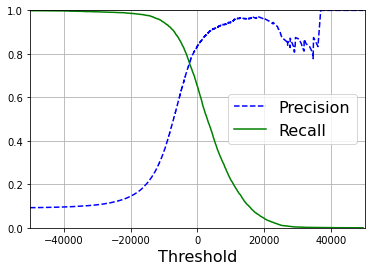

In [ ]:
# 맷플롯립을 이용해 임곗값의 함수로 정밀도와 재현율 그리기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  # 임곗값을 표시하고 범례, 축 이름, 그리드를 추가합니다.
  plt.legend(loc="center right", fontsize=16)
  plt.xlabel("Threshold", fontsize=16)
  plt.grid(True)
  plt.axis([-50000, 50000, 0, 1])   

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [ ]:
# 최소한 90% 정밀도가 되는 가장 낮은 임곗값 계산
# np.argmax()는 최댓값의 첫 번째 인덱스를 반환 -> 여기서는 첫 번째 True 값을 의미
threshold_90_decision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_decision

3370.0194991439557

In [ ]:
# predict() 대신 아래 코드를 실행하여 훈련 세트에 대한 예측 생성
y_train_pred_90 = (y_scores >= threshold_90_decision)

In [ ]:
# 예측에 대한 정밀도 확인
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
# 예측에 대한 재현율 확인
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

* 재현율이 너무 낮다면 높은 정밀도의 분류기는 전혀 유용하지 않다는 것을 유의

#### 3.3.5 ROC 곡선
* 수신기 조작 특성 (receiver operating characteristic, ROC) 곡선 : 거짓 양성 비율 (false positive rate, FPR)에 대한 진짜 양성 비율 (true positive rate, TPR, 재현율)의 곡선
 - 이진 분류에서 널리 사용
 - 정밀도/재현율 곡선과 유사
 - FPR : 양성으로 잘못 분류된 음성 샘플의 비율
    - FPR = 1 - 진짜 음성 비율 (true negative rate, TNR, 특이도)
  - TNR: 음성으로 정확하게 분류한 음성 샘플의 비율

  => 민감도 (재현율)에 대한 1-특이도 그래프
* ROC 곡선 그리는 방법
  - roc_vurve() 함수로 여러 임곗값에서 TPR과 FPR 계산
  - 맷플롯립으로 TPR에 대한 FPR 곡선 그리기


In [ ]:
# ROC 곡선 그리기
# 여러 임곗값에서 TPR과 FPR 계산
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

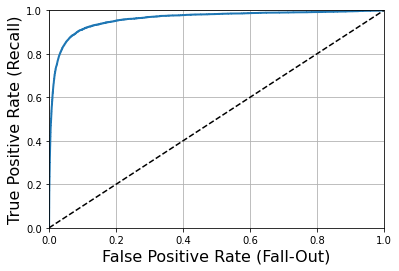

In [ ]:
# TPR에 대한 FPR 곡선 그리기
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--') # 대각 점선
  # 축 이름, 그리드 추가
  plt.axis([0, 1, 0, 1])
  plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
  plt.ylabel('True Positive Rate (Recall)', fontsize=16)
  plt.grid(True)

plot_roc_curve(fpr, tpr)
plt.show()

* ROC 곡선 해석
  - 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어남
  - 점선은 완전한 랜덤 분류기의 ROC 곡선 의미
  - 좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 함 (왼쪽 위 모서리)

* 곡선 아래의 면적(area under the curve, AUC)
  - 완벽한 분류기 : ROC의 AUC가 1
  - 완전한 랜덤 분류기 : ROC의 AUC가 0.5

In [ ]:
# ROC의 AUC 계산
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

* RandomRorestClassifier를 훈련시켜 SGDClassifier의 ROC 곡선과 ROC AUC 점수를 비교
  - 훈련 세트 샘플에 대한 점수
    : decision_fuction() 대신 predict_proba() 이용
    - predict_proba() : 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환

In [ ]:
# RandomRorestClassifier를 훈련시켰을 때 샘플에 대한 점수 계산
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용합니다.
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

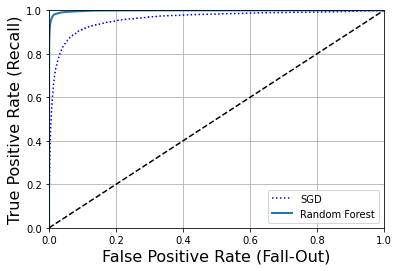

In [ ]:
# ROC 곡선 비교
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

* ROC 곡선 비교

  랜덤 포레스트 분류기가 SGD 분류기보다 훨씬 좋음
  
    -> 랜덤 포레스트의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 AUC 값이 크기 때문

In [ ]:
# ROC AUC 값 확인
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### 3.4 다중 분류
* 다중 분류기 (다항 분류기) : 둘 이상의 클래스를 구별
  - 여러 개의 클래스를 직접 처리 - SGD 분류기, 랜덤 포레스트 분류기, 나이브 베이즈 분류기
  - 이진 분류만 가능한 경우 - 로지스틱 회귀, 서포트 벡터 머신 분류기
    
    -> 이진 분류기를 여러 개 사용해 다중 클래스를 분류 
      
      - 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개를 훈련 -> 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택
    
      => OvR(one-versus-the-rest) 전략 = OvA(one-versus-all) -> 대부분의 이진 분류 알고리즘이 선호

      - 각 숫자의 조합마다 이진 분류기를 훈련 -> 모든 분류기를 통과시켜서 가장 많이 양성으로 분류된 클래스를 선택
      
        클래스 N개 -> 분류기 N * (N-1) / 2개
        
        => OvO(one-versus-one) 전략 : 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요한 것이 장점 -> 훈련 세트의 크기에 민감한 서포트 벡터 머신이 선호
  - 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO 실행

In [ ]:
# 서포트 벡터 머신 분류기 테스트
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train_5가 아니고 y_train을 사용합니다.
svm_clf.predict([some_digit]) # OvO 전략 사용

array([5], dtype=uint8)

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit]) # 샘플 당 10개의 점수 반환
some_digit_scores # 가장 높은 점수가 클래스 5에 해당하는 값

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [ ]:
np.argmax(some_digit_scores)

5

In [ ]:
svm_clf.classes_ # classes_ 속성 : 타깃 클래스의 리스트를 값으로 정렬하여 저장

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

5

* 사이킷런에서 OvO나 OvR을 사용하도록 강제
  - OneVsOneClassifier
  - OneVsRestClassifier

In [ ]:
# SVC 기반으로 OvR 전략 사용하는 다중 분류기 생성
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
# SGDClassifier 훈련
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
# SGD 분류기가 부여한 점수 확인
sgd_clf.decision_function([some_digit]) # 클래스마다 하나의 값을 반환
# 분류기가 예측 결과에 강한 확신

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
# SGDClassifier 정확도 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
# 입력 스케일 조정하여 정확도 향상
from sklearn.preprocessing import StandardScaler
sclaer = StandardScaler()
X_train_scaled = sclaer.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### 3.5 에러 분석

* 오차 행렬

In [ ]:
# 오차 행렬
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3) # 예측 생성
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx # 대부분의 이미지가 주대각선에 위치 -> 올바르게 분류

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

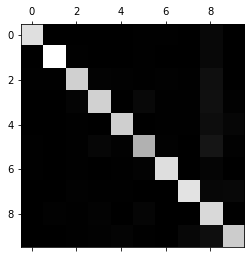

In [ ]:
# 오차 행렬을 이미지로 표현
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

* 오차 행렬 이미지 해석 
  - 배열에서 가장 큰 값은 흰색, 가장 작은 값은 검은색으로 정규화
  - 숫자 5는 다른 숫자보다 조금 더 어두움
    - 원인 1 : 데이터셋에 숫자 5의 이미지가 적음
    - 원인 2 : 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못함

In [ ]:
# 에러 비율 비교
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

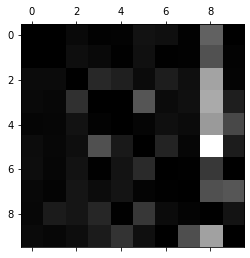

In [ ]:
# 그래프 그리기
np.fill_diagonal(norm_conf_mx, 0) # 주대각선 0으로 채움
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

* 그래프 해석
  - 행 : 실제 클래스
    
    열 : 예측한 클래스
  - 클래스 8의 열이 밝음 -> 많은 이미지가 8로 잘못 분류
    
    클래스 8의 행은 괜찮음 -> 실제 8이 적절히 8로 분류
  
    => 오차 행렬이 반드시 대칭인 것은 아님
  - 3과 5가 많이 혼동됨

* 성능 향상 방안
  - 8로 잘못 분류되는 것을 줄이도록 개선
  - 분류기에 도움 될 만한 특성 찾기
    예) 동심원의 수를 세는 알고리즘
  - 패턴이 드러나도록 이미지 전처리

In [ ]:
# plot_digits() 정의 - 깃허브 주피터 노트북 참고
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

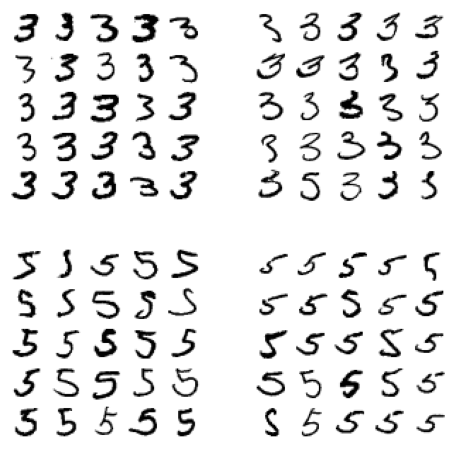

In [ ]:
# 3과 5의 샘플 그리기
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

* 왼쪽의 5 * 5 블록 두 개 : 3으로 분류된 이미지
* 오른쪽의 5 * 5 블록 두 개 : 5로 분류된 이미지
* 오류 원인 : 선형 모델인 SGDClassifier를 사용했기 때문
  - 선형 분류기는 클래스마다 픽셀에 가중치 할당 -> 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산
  
    => 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동
* 개선 방안 : 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리 (분류기가 이미지의 위치나 회전 방향에 매우 민감하기 때문)

### 3.6 다중 레이블 분류
* 다중 레이블 분류 시스템 : 여러 개의 이진 꼬리표(tag)를 출력하는 분류 시스템

In [ ]:
# 각 숫자 이미지에 두 개의 타깃 레이블이 담긴 배열 생성
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier() # 다중 레이블 분류 지원
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit]) # 레이블 두 개 출력 -> 올바르게 분류

array([[False,  True]])

In [ ]:
# 다중 레이블 분류기 평가
# 모든 레이블에 대한 F1 점수 평균 계산 -> 모든 레이블의 가중치 동일 가정
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

* 레이블에 클래스의 지지도(support, 타깃 레이블에 속한 샘플 수)를 가중치로 주려면 `average="weighted"`로 설정

### 3.7 다중 출력 분류
* 다중 출력 클래스 분류 (다중 출력 분류) : 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화 -> 값을 두 개 이상 가질 수 있음
* 이미지에서 잡음을 제거하는 시스템
  - 입력 : 잡음이 많은 숫자 이미지
  - 출력 : 깨끗한 숫자 이미지의 픽셀 강도를 담은 배열

In [ ]:
# MNIST 이미지에서 추출한 훈련 / 테스트 세트 픽셀 강도에 잡음 추가
# 타깃 이미지는 원본 이미지
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
# plot_digit() 함수 정의
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

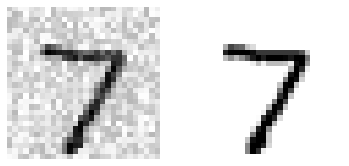

In [ ]:
# 테스트 세트에서 이미지 선택
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index]) # 잡음이 섞인 입력 이미지
plt.subplot(122); plot_digit(y_test_mod[some_index]) # 깨끗한 타깃 이미지
plt.show()

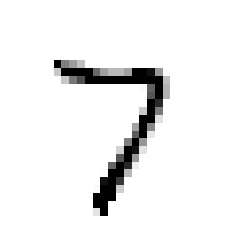

In [ ]:
# 분류기를 훈련시켜 이미지를 깨끗하게 만들기
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)